<a href="https://colab.research.google.com/github/Kharleel/Kharleel/blob/main/Copy_of_Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Using GPU for training.
Iteration 1/5
Iteration 2/5
Iteration 3/5
Iteration 4/5
Iteration 5/5

✅ Optimal Parameters Found:
📌 Number of Units: 234
📌 Dropout Rate: 0.45
📌 Learning Rate: 0.0029
📌 Final Accuracy: 0.4500
⏳ Training completed in: 0:05:22.823485


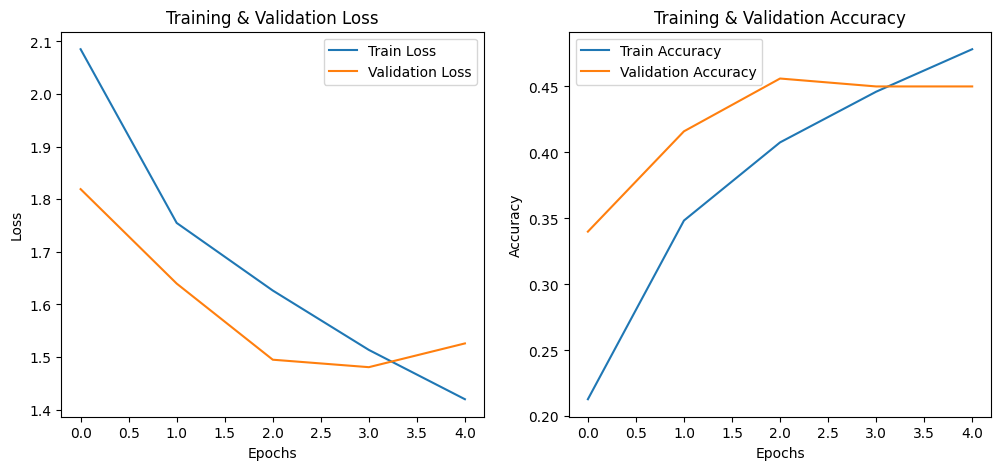

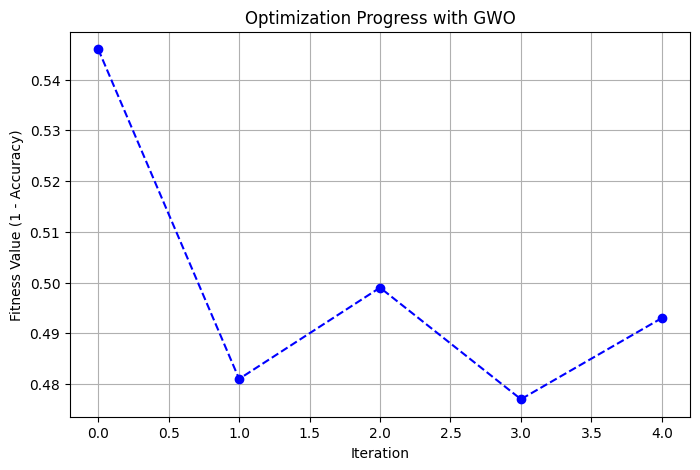

🎉 Final trained model saved successfully!


In [ ]:
# Install necessary libraries (if running in Colab)
# !pip install tensorflow matplotlib

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Check for GPU availability
device_name = "GPU" if tf.config.list_physical_devices('GPU') else "CPU"
print(f"Using {device_name} for training.")

# Grey Wolf Optimization (GWO) implementation
class GreyWolfOptimizer:
    def __init__(self, fitness_function, dim, lb, ub, population_size=5, max_iter=5):
        self.fitness_function = fitness_function
        self.dim = dim
        self.lb = np.array(lb)
        self.ub = np.array(ub)
        self.population_size = population_size
        self.max_iter = max_iter
        self.population = np.random.uniform(self.lb, self.ub, (population_size, dim))
        self.alpha, self.beta, self.delta = None, None, None
        self.fitness_history = []  # Store best fitness over iterations

    def optimize(self):
        for iteration in range(self.max_iter):
            print(f"Iteration {iteration + 1}/{self.max_iter}")

            # Evaluate fitness for each solution
            fitness_values = np.array([self.fitness_function(ind) for ind in self.population])
            sorted_indices = np.argsort(fitness_values)
            self.alpha = self.population[sorted_indices[0]].copy()
            self.beta = self.population[sorted_indices[1]].copy()
            self.delta = self.population[sorted_indices[2]].copy()

            # Store best fitness value
            self.fitness_history.append(fitness_values[sorted_indices[0]])

            a = 2 - iteration * (2 / self.max_iter)

            for i in range(self.population_size):
                for j in range(self.dim):
                    r1, r2 = np.random.rand(), np.random.rand()
                    A1, C1 = 2 * a * r1 - a, 2 * r2
                    D_alpha = abs(C1 * self.alpha[j] - self.population[i, j])
                    X1 = self.alpha[j] - A1 * D_alpha

                    r1, r2 = np.random.rand(), np.random.rand()
                    A2, C2 = 2 * a * r1 - a, 2 * r2
                    D_beta = abs(C2 * self.beta[j] - self.population[i, j])
                    X2 = self.beta[j] - A2 * D_beta

                    r1, r2 = np.random.rand(), np.random.rand()
                    A3, C3 = 2 * a * r1 - a, 2 * r2
                    D_delta = abs(C3 * self.delta[j] - self.population[i, j])
                    X3 = self.delta[j] - A3 * D_delta

                    self.population[i, j] = (X1 + X2 + X3) / 3
                    self.population[i, j] = np.clip(self.population[i, j], self.lb[j], self.ub[j])

        return self.alpha

# CNN Model Definition and Fitness Function
def create_and_train_cnn(num_units=128, dropout=0.5, learning_rate=0.001, weights=None):
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    # Use only a subset for faster evaluation
    x_train, y_train = x_train[:5000], y_train[:5000]
    x_test, y_test = x_test[:1000], y_test[:1000]

    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    y_train = to_categorical(y_train, num_classes=10)
    y_test = to_categorical(y_test, num_classes=10)

    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(num_units, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy', metrics=['accuracy'])

    if weights is not None:
        model.set_weights(weights)

    history = model.fit(x_train, y_train, epochs=5, batch_size=64, verbose=0, validation_data=(x_test, y_test))
    _, accuracy = model.evaluate(x_test, y_test, verbose=0)

    return 1 - accuracy, model.get_weights(), history

# Fitness Function for GWO
def fitness_function(params):
    num_units, dropout, learning_rate = int(params[0]), params[1], params[2]
    error, _, _ = create_and_train_cnn(num_units, dropout, learning_rate)
    return error

# Main execution
dim = 3
lb = [16, 0.1, 0.0001]  # Lower bounds: num_units, dropout, learning_rate
ub = [256, 0.5, 0.01]   # Upper bounds: num_units, dropout, learning_rate

start = datetime.now()

optimizer = GreyWolfOptimizer(fitness_function, dim, lb, ub, population_size=5, max_iter=5)
best_params = optimizer.optimize()

num_units, dropout, learning_rate = int(best_params[0]), best_params[1], best_params[2]
final_error, final_weights, final_history = create_and_train_cnn(num_units, dropout, learning_rate)
final_accuracy = 1 - final_error

print("\n✅ Optimal Parameters Found:")
print(f"📌 Number of Units: {num_units}")
print(f"📌 Dropout Rate: {dropout:.2f}")
print(f"📌 Learning Rate: {learning_rate:.4f}")
print(f"📌 Final Accuracy: {final_accuracy:.4f}")

duration = datetime.now() - start
print(f"⏳ Training completed in: {duration}")

# Visualization: Training Loss & Accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(final_history.history['loss'], label="Train Loss")
plt.plot(final_history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(final_history.history['accuracy'], label="Train Accuracy")
plt.plot(final_history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()

# Plot Optimization Progress
plt.figure(figsize=(8, 5))
plt.plot(optimizer.fitness_history, marker="o", linestyle="--", color="b")
plt.xlabel("Iteration")
plt.ylabel("Fitness Value (1 - Accuracy)")
plt.title("Optimization Progress with GWO")
plt.grid()
plt.show()

# Save Model
final_model = create_and_train_cnn(num_units, dropout, learning_rate)[1]  # Get trained weights
final_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(num_units, activation='relu'),
    layers.Dropout(dropout),
    layers.Dense(10, activation='softmax')
])

final_model.set_weights(final_weights)
final_model.save('/content/drive/MyDrive/cifar10_gwo_model.h5')
print("🎉 Final trained model saved successfully!")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10

Optimal Parameters:
Number of Units: 243
Dropout Rate: 0.10
Learning Rate: 0.0013
Final Accuracy: 0.6847
Training completed in time:  1:21:31.502955


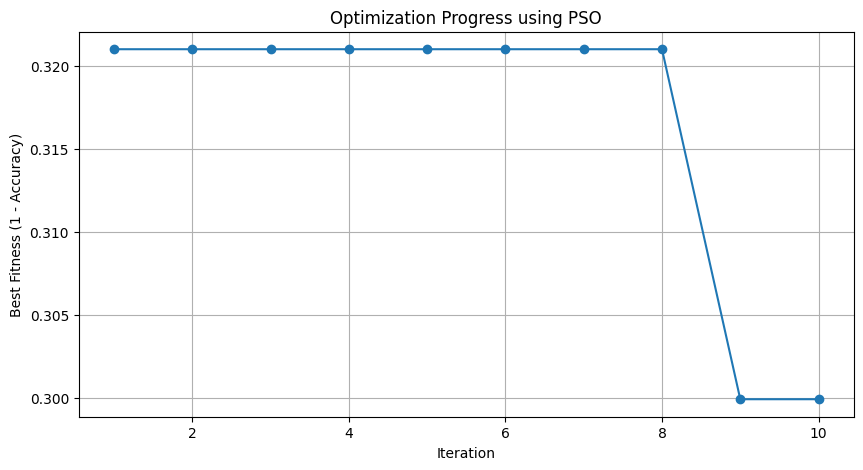

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Particle Swarm Optimization (PSO) Implementation
class PSO:
    def __init__(self, fitness_function, dim, lb, ub, num_particles=15, max_iter=10):
        self.fitness_function = fitness_function
        self.dim = dim
        self.lb = np.array(lb)
        self.ub = np.array(ub)
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.w = 0.7  # Inertia weight
        self.c1 = 1.5  # Cognitive coefficient
        self.c2 = 1.5  # Social coefficient

        self.particles = np.random.uniform(self.lb, self.ub, (num_particles, dim))
        self.velocities = np.random.uniform(-1, 1, (num_particles, dim))
        self.personal_best = self.particles.copy()
        self.personal_best_fitness = np.array([self.fitness_function(p) for p in self.particles])
        self.global_best = self.personal_best[np.argmin(self.personal_best_fitness)].copy()
        self.global_best_fitness = np.min(self.personal_best_fitness)
        self.best_fitness_per_iteration = []  # Store best fitness at each iteration

    def optimize(self):
        for iteration in range(self.max_iter):
            print(f"Iteration {iteration + 1}/{self.max_iter}")
            for i in range(self.num_particles):
                fitness = self.fitness_function(self.particles[i])

                if fitness < self.personal_best_fitness[i]:
                    self.personal_best_fitness[i] = fitness
                    self.personal_best[i] = self.particles[i].copy()

                if fitness < self.global_best_fitness:
                    self.global_best_fitness = fitness
                    self.global_best = self.particles[i].copy()

                r1, r2 = np.random.rand(self.dim), np.random.rand(self.dim)
                cognitive = self.c1 * r1 * (self.personal_best[i] - self.particles[i])
                social = self.c2 * r2 * (self.global_best - self.particles[i])
                self.velocities[i] = self.w * self.velocities[i] + cognitive + social
                self.particles[i] = np.clip(self.particles[i] + self.velocities[i], self.lb, self.ub)

            self.best_fitness_per_iteration.append(self.global_best_fitness)

        return self.global_best

# CNN Model Definition and Fitness Function
def create_and_train_cnn(num_units=128, dropout=0.5, learning_rate=0.001):
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train, x_test = x_train.astype('float32') / 255.0, x_test.astype('float32') / 255.0
    y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)

    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(num_units, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(x_train, y_train, epochs=5, batch_size=64, verbose=0)
    _, accuracy = model.evaluate(x_test, y_test, verbose=0)
    return 1 - accuracy

# Fitness Function for PSO
def fitness_function(params):
    num_units, dropout, learning_rate = int(params[0]), params[1], params[2]
    return create_and_train_cnn(num_units, dropout, learning_rate)

# Main execution
lb = [16, 0.1, 0.0001]  # Lower bounds: num_units, dropout, learning_rate
ub = [256, 0.5, 0.01]   # Upper bounds: num_units, dropout, learning_rate
dim = 3

start = datetime.now()
optimizer = PSO(fitness_function, dim, lb, ub, num_particles=15, max_iter=10)
best_params = optimizer.optimize()

num_units, dropout, learning_rate = int(best_params[0]), best_params[1], best_params[2]
final_accuracy = 1 - create_and_train_cnn(num_units, dropout, learning_rate)

duration = datetime.now() - start
print("\nOptimal Parameters:")
print(f"Number of Units: {num_units}")
print(f"Dropout Rate: {dropout:.2f}")
print(f"Learning Rate: {learning_rate:.4f}")
print(f"Final Accuracy: {final_accuracy:.4f}")
print("Training completed in time: ", duration)

# Visualization of PSO Optimization Process
def plot_results():
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(optimizer.best_fitness_per_iteration) + 1), optimizer.best_fitness_per_iteration, marker='o')
    plt.xlabel("Iteration")
    plt.ylabel("Best Fitness (1 - Accuracy)")
    plt.title("Optimization Progress using PSO")
    plt.grid()
    plt.show()

plot_results()
